In [1]:
pip install python-chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import os
import chess
import h5py
from keras.utils import to_categorical
from keras import models, layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Model
# Load the .h5 file
with h5py.File("/kaggle/input/data-of-h5/dataset_all_d4_eval_move_board.h5", "r") as hf:
    feature_board = np.array(hf["feature_board"])
    evaluation = np.array(hf["y_evaluation"])

print("Loaded .h5 file successfully")
print(f"Feature board shape: {feature_board.shape}")
print(f"Best move shape: {evaluation.shape}")

2024-06-09 06:28:28.910682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 06:28:28.910804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 06:28:29.029024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loaded .h5 file successfully
Feature board shape: (4876092, 14, 8, 8)
Best move shape: (4876092,)


In [3]:
def create_model():
    input_layer = Input(shape=(14, 8, 8))
    
    conv_layer_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(input_layer)
    conv_layer_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv_layer_1)
    conv_layer_3 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv_layer_2)
    
    
    flatten_layer = Flatten()(conv_layer_2)
    
    dense_layer_1 = Dense(128, activation='relu')(flatten_layer)
    output_layer = Dense(1, activation='sigmoid')(dense_layer_1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(5e-4), loss="mean_squared_error")
    model.summary()
    return model

In [4]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


feature_board = np.array(feature_board)
evaluation = np.array(evaluation)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(feature_board, evaluation, test_size=0.2, random_state=42)

batch_size = 512  # Adjust batch size to ensure it fits the dataset
epochs_per_cycle = 20  # Number of epochs to train on each batch of moves

# Create the model
model = create_model()
# Define the callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitors the validation loss
    factor=0.1,          # Factor by which the learning rate will be reduced
    patience=10,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6          # Lower bound on the learning rate
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors the validation loss
    patience=15,         # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-4,      # Minimum change to qualify as an improvement
    restore_best_weights=True  # Restores the weights of the best epoch
)


# Train the model using the training and validation data
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    verbose=1,
    epochs=epochs_per_cycle,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping]  # Add the callbacks here
)

# Optionally, you can print the history to see the training progress
print(history.history)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 8, 128)     │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 8, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14336)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,835,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,992,193 (7.60 MB)

 Trainable params: 1,992,193 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-06-09 06:29:25.525446: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2023: 7.45669, expected 6.56073
2024-06-09 06:29:25.525509: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2127: 7.92549, expected 7.02954
2024-06-09 06:29:25.525540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2919: 5.95515, expected 5.19471
2024-06-09 06:29:25.525585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4151: 6.23579, expected 5.2907
2024-06-09 06:29:25.525604: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4599: 6.307, expected 5.46037
2024-06-09 06:29:25.525618: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4703: 6.65349, expected 5.80687
2024-06-09 06:29:25.525631: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4927: 6.98068, expected 6.14186
2024-06-09 06:29:25.525648: E externa

  22/7619 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - loss: 0.0042

I0000 00:00:1717914567.726261     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717914567.743129     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7615/7619 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4698e-04

2024-06-09 06:30:23.273014: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 336: 7.86442, expected 6.93861
2024-06-09 06:30:23.273072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 343: 7.21062, expected 6.28481
2024-06-09 06:30:23.273081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 455: 6.96279, expected 6.08474
2024-06-09 06:30:23.273089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 559: 7.50027, expected 6.62221
2024-06-09 06:30:23.273098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 679: 7.54926, expected 6.68049
2024-06-09 06:30:23.273108: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1239: 7.65353, expected 6.74035
2024-06-09 06:30:23.273116: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1336: 6.78534, expected 5.87216
2024-06-09 06:30:23.273123: E external/

7619/7619 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4687e-04

W0000 00:00:1717914624.992474     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717914627.381019     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-09 06:30:33.175563: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 216: 8.03175, expected 7.12236
2024-06-09 06:30:33.175626: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1575: 7.2382, expected 6.38894
2024-06-09 06:30:33.175658: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6167: 7.4424, expected 6.55795
2024-06-09 06:30:33.175667: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6615: 6.66562, expected 5.75657
2024-06-09 06:30:33.175676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6719: 7.67506, expected 6.76601
2024-06-09 06:30:33.175683: E external/local_xla/xla/service/gp

7619/7619 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - loss: 3.4684e-04 - val_loss: 1.8889e-05 - learning_rate: 5.0000e-04
Epoch 2/20


W0000 00:00:1717914633.734690     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 1.2305e-05 - val_loss: 5.5095e-06 - learning_rate: 5.0000e-04
Epoch 3/20
7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 4.7171e-06 - val_loss: 2.7916e-06 - learning_rate: 5.0000e-04
Epoch 4/20
7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 2.9021e-06 - val_loss: 2.7942e-06 - learning_rate: 5.0000e-04
Epoch 5/20
7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 2.4021e-06 - val_loss: 2.5571e-06 - learning_rate: 5.0000e-04
Epoch 6/20
7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 2.2209e-06 - val_loss: 2.2762e-06 - learning_rate: 5.0000e-04
Epoch 7/20
7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 2.5447e-06 - val_loss: 2.6362e-06 - learning_rate: 5.0000e-04
Epoch 8/20
7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 2.3589e-06 - val_loss: 1.9294e-06 - learning_rate: 5.0000e-04
Epoch 9/20
7619/7619 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 2.0095e-06 - val_loss: 1.7767e-06 - learning_rate: 5.0000e-04
Epoch 10/20

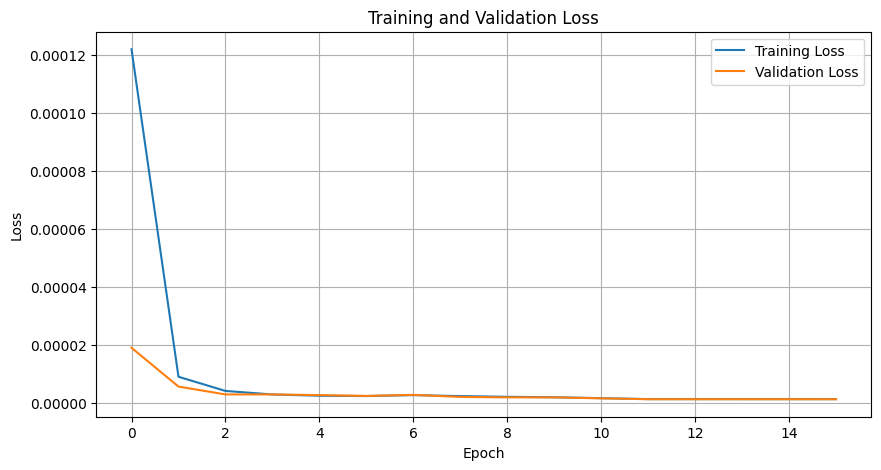

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [8]:
# Save model after training
model.save(f"/kaggle/working/modeldepth_4_evaluations.h5")

In [1]:
import numpy as np
import h5py

# Load the .h5 file
with h5py.File("/kaggle/input/data-of-h5/dataset_all_d4_eval_move_board.h5", "r") as hf:
    feature_board = np.array(hf["feature_board"])
    best_move = np.array(hf["best_move"])
    evaluation = np.array(hf["y_evaluation"])

print("Loaded .h5 file successfully")
print(f"Feature board shape: {feature_board.shape}")
print(f"Best move shape: {best_move.shape}")
print(f"evaluation: {evaluation.shape}")



Loaded .h5 file successfully
Feature board shape: (4876092, 14, 8, 8)
Best move shape: (4876092,)
evaluation: (4876092,)


In [ ]:
import numpy as np

# Assuming feature_board, moves, and evaluation are already loaded and processed

# Reshape feature_board to a 2D array where each row is a flattened board
num_samples = feature_board.shape[0]
flattened_feature_board = feature_board.reshape(num_samples, -1)

# Find the unique boards and their indices
unique_boards, unique_indices = np.unique(flattened_feature_board, axis=0, return_index=True)

# Get the unique boards in their original shape
unique_feature_board = unique_boards.reshape(-1, 14, 8, 8)

# Get the corresponding moves and evaluations
unique_moves = moves[unique_indices]
unique_evaluation = evaluation[unique_indices]

print("Number of unique data", len(unique_moves))
print(f"Unique feature board shape: {unique_feature_board.shape}")
print(f"Unique moves shape: {unique_moves.shape}")
print(f"Unique evaluation shape: {unique_evaluation.shape}")

Finding unique boards:   0%|          | 228/4876092 [02:25<1183:30:57,  1.14it/s]

In [4]:
import numpy as np
import h5py
from tqdm import tqdm  # For progress tracking

# Assuming feature_board, best_move, and evaluation are already loaded and processed

# Create an empty set to store unique boards
unique_boards_set = set()

# Create lists to store unique moves and evaluations
unique_moves = []
unique_evaluation = []

# Track progress using tqdm
progress_bar = tqdm(total=len(feature_board), desc="Finding unique boards")

# Iterate through feature boards
for board, move, eval_value in zip(feature_board, best_move, evaluation):
    # Convert the board to a tuple to make it hashable
    board_tuple = tuple(map(tuple, board))
    
    # Check if the current board is unique
    if board_tuple not in unique_boards_set:
        unique_boards_set.add(board_tuple)
        unique_moves.append(move)
        unique_evaluation.append(eval_value)
    
    # Update progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Convert unique boards set back to numpy array
unique_boards = np.array([np.array(board).astype(int) for board in unique_boards_set])

# Convert lists to numpy arrays
unique_moves = np.array(unique_moves)
unique_evaluation = np.array(unique_evaluation)

print("Number of unique data:", len(unique_moves))
print(f"Unique feature board shape: {unique_boards.shape}")
print(f"Unique best move shape: {unique_moves.shape}")
print(f"Unique evaluation shape: {unique_evaluation.shape}")

Finding unique boards:   0%|          | 0/4876092 [00:00<?, ?it/s]

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
# Optionally, save the unique boards and moves to a new .h5 file
with h5py.File("/kaggle/working/unique_dataset.h5", "w") as hf_unique:
    hf_unique.create_dataset("feature_board", data=unique_feature_board)
    hf_unique.create_dataset("best_move", data=unique_moves.astype('S'), dtype=h5py.string_dtype(encoding='utf-8'))
    hf_unique.create_dataset("evaluation", data=unique_evaluation.astype(np.int8))

print("Saved unique boards and moves to unique_dataset.h5")